# Time Series Analysis of Stock Indices

## 1. Load Data

In [143]:
import numpy as np
import pandas as pd
import seaborn as sns

In [144]:
df1=pd.read_csv('stockIndices - nifty50.csv')
df2=pd.read_csv('stockIndices - sensex.csv')
df3=pd.read_csv('stockIndices - niftybank.csv')


## 2. Preprocessing
Combine dataframes, set date as index and remove null rows.

In [145]:
for df in (df1, df2, df3):
  df.set_index("Date", inplace=True)
  df.index = pd.to_datetime(df.index)

In [146]:
df.head()


,Open,High,Low,Close,Volume
Date,,,,,
2006-11-13 15:30:00,5773.25,5823.95,5730.85,5801.35,0
2006-11-16 15:30:00,6039.20,6268.25,6039.20,6175.05,0
2006-11-17 15:30:00,6166.45,6228.25,6066.15,6119.65,0
2006-11-20 15:30:00,6115.95,6115.95,5907.45,6006.60,0
2006-11-21 15:30:00,6045.05,6101.80,6009.10,6085.50,0


In [147]:
df=pd.DataFrame({"Nifty":[],"Sensex":[],"NiftyBank":[]})
symbols=["Nifty","Sensex","NiftyBank"]
df.Nifty=df1.Close
df.Sensex=df2.Close
df.NiftyBank=df3.Close
df=df.dropna()

##3. Visualise Time series

In [148]:
def split_data(arr):
  finalModel={}
  pred={}
  train_data=pd.DataFrame() # splitting into test and train data
  test_data=pd.DataFrame()
  for i, sym in enumerate(symbols): # for all 3 stocks
        train_data[sym], test_data[sym] = df[sym][1:int(len(df[sym])*0.8)], df[sym][int(len(df)*0.8):]


  return train_data,test_data

In [149]:
df=df.dropna()
train,test=split_data(df)

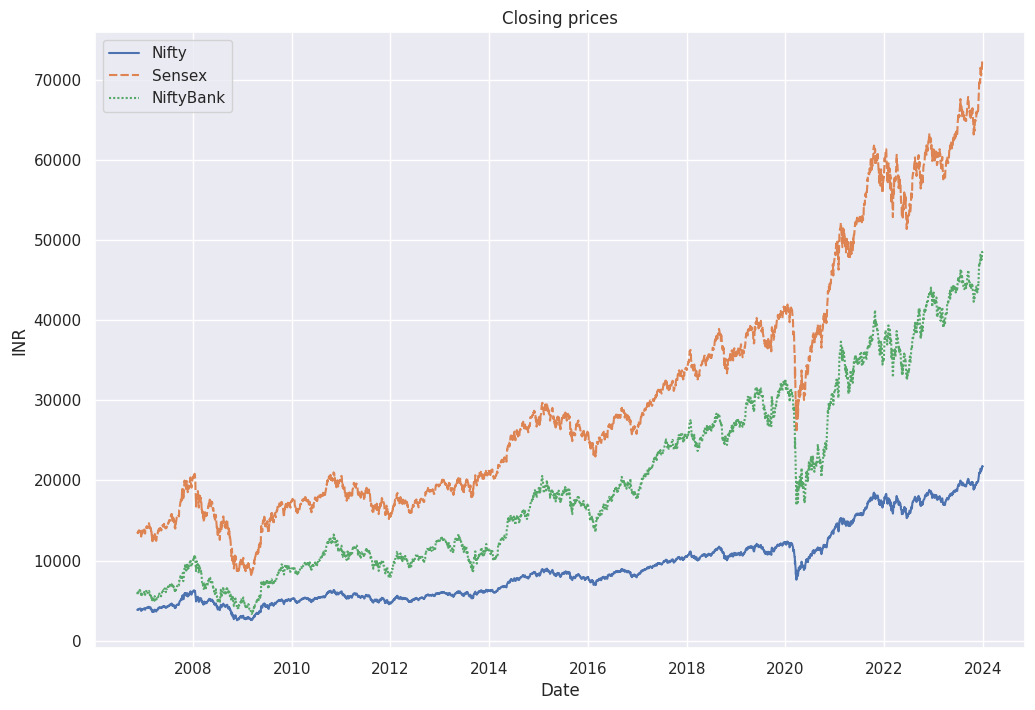

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns
# yearlyData= closingPrices.loc[(closingPrices.index.year == 2016)  ]
plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid")
sns.lineplot(data=df)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('INR')
plt.title('Closing prices')
plt.show()

Checking sarima models for varying values of m and returning best model found at some m for all 3 indices.

The ACF, PACF and Q stats for Nifty and Sensex point towards residuals being random white noise, proving that there is no autocorrelation among residuals and model is a decent fit. For NiftyBank, there appears to be some correlation after 5 lags.

## LSTM

In [151]:
# @title import

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import ParameterSampler
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset



In [152]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the LSTM model class with flexible hyperparameters
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define LSTM layers and dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Output layer at the last time step
        return out

Using device: cuda


In [153]:
# Model Parameters
input_size = 1
hidden_size = 50
num_layers = 2
output_size = 1
droupout_rate = 0.2
num_epochs = 100

# Instantiate the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, droupout_rate, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [154]:
# Function to prepare data with closing price and residuals as inputs
def prepare_lstm_data(prices, sequence_length):
    data = prices
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(prices[i + sequence_length])  # Target is price at t + sequence_length
    return np.array(X), np.array(y)

In [155]:
# Example hyperparameter grid
param_grid = {
    'hidden_size': [250],
    'dropout_rate': [0.1],
    'optimizer': ['AdamW'],
    'learning_rate': [ 0.0001],
    'sequence_length': [14]
}

# Generate random search sample of parameter combinations
n_combinations = 1
param_combinations = list(ParameterSampler(param_grid, n_iter=n_combinations))
index_n = 3
count = 0

In [156]:
sequence_length = 14
for i, sym in enumerate(symbols):
      close = np.array(train[sym]).reshape(-1, 1)
      count += 1
      if(count>=index_n):
        stock_name = sym
        break
#  closing_prices = np.random.rand(1000, 1)  # Replace with actual closing price data
#  arima_residuals = np.random.rand(1000, 1)  # Replace with actual ARIMA residuals
print(close.shape)
# Scale both closing prices and residuals
scaler_prices = MinMaxScaler()
close = scaler_prices.fit_transform(close)

# Prepare LSTM inputs and targets
X, y = prepare_lstm_data(close, sequence_length)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

train_data = TensorDataset(X, y)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)


(3349, 1)


In [157]:
# Function to train model with given hyperparameters
def train_model(params, train_loader):
    input_size = 1  # Two input features: closing price and residuals
    output_size = 1

    # Initialize model
    model = LSTMModel(
        input_size=input_size,
        hidden_size=params['hidden_size'],
        num_layers=2,  # Fixed to 2 layers
        dropout_rate=params['dropout_rate'],
        output_size=output_size
    ).to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=params['learning_rate'])

    # Training loop
    model.train()
    for epoch in range(num_epochs):  # Adjust epochs as needed
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model, loss.item()

In [158]:
# Run random search
best_model = None
best_loss = float('inf')
best_params = None

for params in param_combinations:
    print(f"Testing combination: {params}")
    model, loss = train_model(params, train_loader)
    print(f"Loss: {loss}")

    if loss < best_loss:
        best_loss = loss
        best_model = model
        best_params = params

print("Best hyperparameters:", best_params)
print("Best loss:", best_loss)

Testing combination: {'sequence_length': 14, 'optimizer': 'AdamW', 'learning_rate': 0.0001, 'hidden_size': 250, 'dropout_rate': 0.1}
Loss: 0.0018626891542226076
Best hyperparameters: {'sequence_length': 14, 'optimizer': 'AdamW', 'learning_rate': 0.0001, 'hidden_size': 250, 'dropout_rate': 0.1}
Best loss: 0.0018626891542226076


In [159]:
# Function to test the model
def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    criterion = nn.MSELoss()
    test_loss = 0.0
    predictions = []
    actuals = []

    with torch.no_grad():  # Disable gradient computation for testing
        for inputs in test_loader:
            inputs = inputs[0].to(device)  # Only inputs, no labels
            outputs = model(inputs)

            # Storing predictions
            predictions.append(outputs.cpu().numpy())

            # Store the actual closing price at the prediction point (end of each sequence)
            actuals.append(inputs[:, -1, 0].cpu().numpy())  # Closing price at the end of each sequence

    # Flatten predictions and actuals
    predictions = np.concatenate(predictions).flatten()
    actuals = np.concatenate(actuals).flatten()

    return predictions, actuals


In [160]:
# Function to prepare test data with the same structure as training data
def prepare_lstm_test_data(test_close,  sequence_length):
    # Combine close price and residual as features
    test_close = scaler_prices.transform(test_close)
    test_data = test_close

    print(test_data.shape)
    X_test = []
    for i in range(len(test_data) - sequence_length):
        X_test.append(test_data[i:i + sequence_length])
    return np.array(X_test)

In [161]:
def create_test_loader(test_close, sequence_length, batch_size=32):
    # Prepare LSTM test inputs
    X_test = prepare_lstm_test_data(test_close, sequence_length)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    print(X_test_tensor.shape)
    test_dataset = TensorDataset(X_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return test_loader

In [162]:
count = 0
for i, sym in enumerate(symbols):
      test_close = np.array(test[sym]).reshape(-1, 1)
      count += 1
      if(count>=index_n):
        break
# Create test loader
test_loader = create_test_loader(test_close, 14)

# Evaluate the best model
test_predictions, test_actuals = evaluate_model(best_model, test_loader)
# Inverse transform predictions and actuals to original scale
# print(test_predictions)
# print("bruh")
# print(test_actuals)
test_predictions = scaler_prices.inverse_transform(test_predictions.reshape(-1, 1))

test_actuals =  scaler_prices.inverse_transform(test_actuals.reshape(-1, 1))
print(test_predictions.shape)
print(test_actuals.shape)


(838, 1)
torch.Size([824, 14, 1])
(824, 1)
(824, 1)


In [163]:
# Function to evaluate model and calculate regression metrics including MAPE
def evaluate_and_print_metrics(predictions, actuals):
    # Flatten predictions and actuals
    predictions = predictions.flatten()
    actuals = actuals.flatten()

    # Calculate regression metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)

    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    # Print metrics
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

    return {
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "MAPE": mape
    }


Mean Squared Error (MSE): 1257700.8750
Root Mean Squared Error (RMSE): 1121.4727
R-squared (R²): 0.9615
Mean Absolute Percentage Error (MAPE): 2.6554%


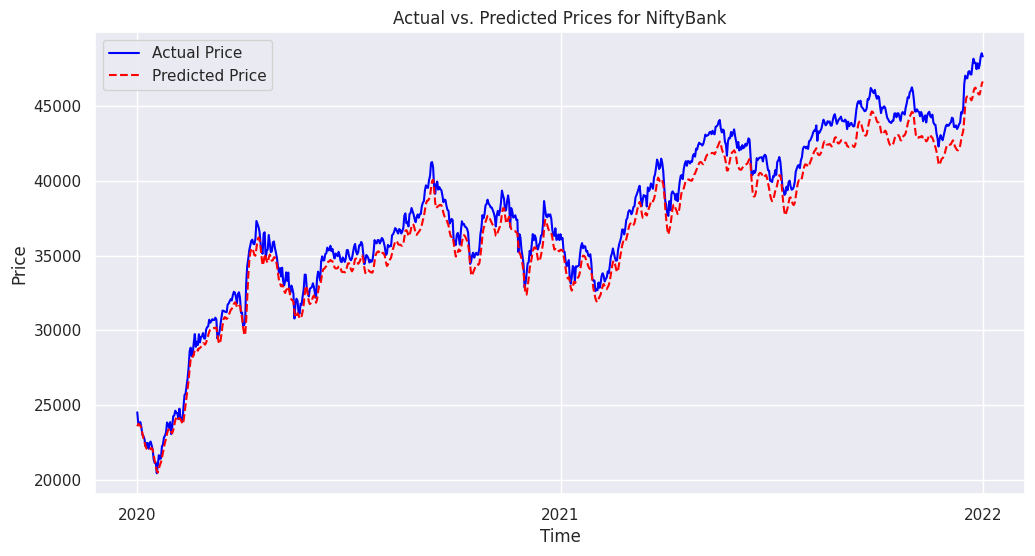

In [164]:
# Print average test loss and example predictions
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Call the function with test predictions and actuals
metrics = evaluate_and_print_metrics(test_predictions, test_actuals)


# Define the positions where you want the xticks
xticks_positions = [0, len(test_actuals) // 2, len(test_actuals) - 1]  # Start, middle, end
xticks_labels = ['2020', '2021', '2022']  # Labels for the xticks

plt.figure(figsize=(12, 6))
plt.plot(test_actuals, label="Actual Price", color="blue")
plt.plot(test_predictions, label="Predicted Price", color="red", linestyle="--")

# Setting custom xticks
plt.xticks(xticks_positions, xticks_labels)

plt.xlabel("Time")
plt.ylabel("Price")
plt.title(f"Actual vs. Predicted Prices for {stock_name}")
plt.legend()
plt.show()
